In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import binet as bt
%matplotlib inline

### Import raw data

In [4]:
#Either directly from Atlas of Economic Complexity

# wt, pr, co = bt.trade_data('hs02')
# wt = wt[(wt.ccode != 'xxa')&(wt.ccode != 'xxb')]

#Or from file if you have it.
wt = pd.read_csv('wt.csv')
pr = pd.read_csv('pr.csv')
co = pd.read_csv('co.csv')

In [9]:
len(wt)

1735634

### Example RCAs
#### This is just to look into how the RCA of some c, p, y comes about.

In [3]:
from decimal import Decimal

def example_RCA(ccode, pcode, year):

    print 'RCA of '+co.loc[co.ccode == ccode]['name'].values[0]+' in '+pr.loc[pr.pcode == pcode]['name'].values[0]+', in year '+str(year)+'\n'

    xcp = wt.loc[(wt.ccode == ccode)&(wt.pcode == pcode)&(wt.year == year)]['x'].values[0]
    Xc = wt.loc[(wt.ccode == ccode)&(wt.year == year)]['x'].sum()
    Xp = wt.loc[(wt.pcode == pcode)&(wt.year == year)]['x'].sum()
    X = wt.loc[wt.year == year]['x'].sum()
    RCA = np.true_divide(xcp * X, Xc * Xp)

    print '(xcp / Xc) / ( Xp / X) = ('+str("{:.2E}".format(Decimal(xcp)))+' / '+str("{:.2E}".format(Decimal(Xc)))+') / ( '+str("{:.2E}".format(Decimal(Xp)))+' / '+str("{:.2E}".format(Decimal(X)))+')'
    print str(100*xcp/Xc)+'% / '+str(100*Xp/X)+'% = '+str(RCA)+'\n \n'

    
# example_RCA('chn', 5002, 2003)
# example_RCA('and', 7001, 2003)
# example_RCA('rwa', 2609, 2005)
example_RCA('usa', 7416, 2011)
example_RCA('ita', 8703, 2014)


RCA of United States in Copper springs., in year 2011

(xcp / Xc) / ( Xp / X) = (1.78E+3 / 1.37E+12) / ( 1.78E+3 / 1.77E+13)
1.30148809426e-07% / 1.00730287963e-08% = 12.9205239118
 

RCA of Italy in Motor cars and other motor vehicles principally designed for the transport  ..., in year 2014

(xcp / Xc) / ( Xp / X) = (1.20E+10 / 5.11E+11) / ( 7.00E+11 / 1.73E+13)
2.35732129213% / 4.04360417706% = 0.58297528366
 



### Snippet of the dataset and print to latex

In [4]:
wt.columns = ['i','year','ccode','pcode','x']
print wt[['year','ccode','pcode','x']].sample(5).to_latex()

\begin{tabular}{lrlrr}
\toprule
{} &  year & ccode &  pcode &             x \\
\midrule
1024259 &  2010 &   nga &   5515 &  3.557100e+04 \\
1459751 &  2013 &   mar &   1209 &  6.975807e+06 \\
1718045 &  2014 &   usa &   8484 &  1.138916e+09 \\
353922  &  2005 &   grc &   7014 &  4.954500e+04 \\
1322554 &  2012 &   tgo &   9506 &  1.102900e+04 \\
\bottomrule
\end{tabular}



## Now we make up the dataset.
### First calculate RCA for all years

In [3]:
#Crea columnas: 'RCA_yr'

RCA_yr = pd.DataFrame()
i = 0
for yr in range(2003,2015):
    RCA = bt.calculateRCA(wt.loc[wt.year == yr], c = 'ccode', p = 'pcode', x = 'x')
    
    RCA = RCA[['ccode','pcode','RCA']].rename(columns={'RCA': 'RCA_'+str(yr)})
    if i:
        RCA_yr = RCA_yr.merge(RCA, on=['ccode','pcode'], how = 'outer')
    else:
        RCA_yr = RCA
        i = 1

RCA_yr = RCA_yr.fillna(0)

RCA_cols = [col for col in RCA_yr if 'RCA' in col]

for col in RCA_cols:
    RCA_yr[col+'_bin'] = (RCA_yr[col] >= 1).astype(int)
    


In [4]:
#Fill non-reported products to make dataset homogeneous.
#Keep countries with most products accounted
counts = RCA_yr.groupby('ccode').count()['pcode']
RCA_yr = RCA_yr.loc[RCA_yr['ccode'].isin(counts.loc[counts > 800].index)]

#Fill RCA_yr
pcodes = sorted(RCA_yr.pcode.unique())
ccodes = sorted(RCA_yr.ccode.unique())

filled_RCA_yr = pd.DataFrame()
c = 0
for ccode in ccodes:
    df = RCA_yr.loc[RCA_yr['ccode'] == ccode]
    df = df.set_index('pcode').reindex(index = pcodes)
    df['ccode'] = ccode
    df.fillna(0)
    if c == 0:
        filled_RCA_yr = df
        c = 1
    else:
        filled_RCA_yr = filled_RCA_yr.append(df)
    
filled_RCA_yr = filled_RCA_yr.reset_index().fillna(0)

#Assign to RCA_yr
RCA_yr = filled_RCA_yr  #You may wish to comment out not to overwrite RCA_yr

### If you need, create density columns

In [7]:
#Crea columnas density

# w_yr = pd.DataFrame()
# i = 0
# for yr in range(2003,2015):
#     datayr = wt[wt['year']==yr][['ccode','pcode','x']].groupby(['ccode','pcode']).sum()[['x']].reset_index()
#     Myr = bt.mcp(data=datayr,c='ccode',p='pcode')
#     Wyr = Myr.densities('pcode')
    
#     Wyr = Wyr[['ccode','pcode','w']].rename(columns={'w': 'w_'+str(yr)})
#     if i:
#         w_yr = w_yr.merge(Wyr, on=['ccode','pcode'])
#     else:
#         w_yr = Wyr
#         i = 1

In [8]:
# dh = pd.DataFrame()
# i = 0
# for yr in range(2003,2005):
#     datayr = wt[wt['year']==yr][['ccode','pcode','x']].groupby(['ccode','pcode']).sum()[['x']].reset_index()
#     Myr = bt.mcp(data=datayr,c='ccode',p='pcode')
#     Wyr = Myr.densities('pcode')
    
#     Wyr = Wyr[['ccode','pcode','w']].rename(columns={'w': 'w_'+str(yr)})
#     if i:
#         dh = dh.merge(Wyr, on=['ccode','pcode'])
#     else:
#         dh = Wyr
#         i = 1
        
# # dh['mean_w'] = dh[['w_2003','w_2004','w_2005']].mean(axis = 1)

# # dh["w_scaled"] = dh.groupby("ccode")['mean_w'].rank(pct = True)

### This function is used to concatenate observations of different years into a single dataflame. 
#### You can choose how to choose the periods, i.e. every 1, 2, ... years, or 1, 2, 3... year-long periods, etc. 

In [82]:
#todo lo que cambia con los anios deberia tener el mismo trato que la col de RCA_yr, ejemplo proximity
def extend_dataset(data, base_cols = [0], step = 1, binary = True, continuous_period = True):

    RCA_bin_cols = data[[col for col in data if 'RCA' and 'bin' in col]]
    RCA_yr_cols = data[[col for col in data if 'RCA' in col and 'bin' not in col]]
    cp_cols = data[['ccode','pcode']]

    c = 0
    for i in base_cols:

        try:
            RCA_fin = RCA_yr_cols.iloc[:, i + step]        
            RCA_ini = RCA_yr_cols.iloc[:,i]

            RCA_bin_fin = RCA_bin_cols.iloc[:, i+step]
            RCA_bin_ini = RCA_bin_cols.iloc[:, i ]        


            batch = cp_cols.join([RCA_ini, RCA_fin, RCA_bin_ini, RCA_bin_fin])
            batch.columns = ['ccode','pcode','RCA', 'RCA_fin', 'RCA_bin_start', 'RCA_bin_end']

            batch['year'] = int(RCA_yr_cols.columns[i][-4:])


            if binary:
                batch = batch.loc[batch.RCA_bin_start.isin([0, 1]) & batch.RCA_bin_end.isin([0, 1])]
                batch.RCA_bin_start = batch.RCA_bin_start.astype(int)
                batch.RCA_bin_end = batch.RCA_bin_end.astype(int)

            if c == 0:
                ext_data = batch
                c = 1
            else:
                ext_data = ext_data.append(batch)
        except IndexError: #When you go out of time period
            pass
    return ext_data

# data = RCA_yr
# base_cols = range(11)
# step = 8
# binary = True


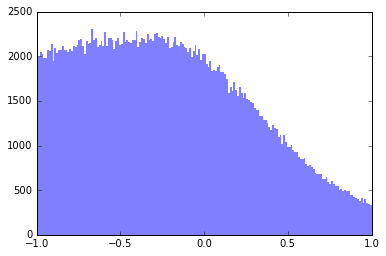

In [81]:
ext_data = extend_dataset_test(RCA_yr, base_cols = range(11), step = 8)

# ext_data = extend_dataset(RCA_yr, base_cols = range(11), step = 8)
# plt.hist(np.log10(ext_data.replace(-np.inf, np.nan).dropna().RCA), 1000, alpha = 0.5, edgecolor = 'None')
plt.hist(np.log10(ext_data.loc[ext_data.RCA_fin>0].RCA_fin), 1000, alpha = 0.5, edgecolor = 'None')
# plt.hist(ext_data.loc[ext_data.RCA < 10].RCA, 1000, alpha = 0.5, edgecolor = 'None', normed = True)
plt.xlim(-1,1)
# plt.xlim(.5, 2)
# plt.ylim(0,.1)
plt.show()

In [85]:
df = pd.DataFrame()

### Compute aggregate exports of country, product and world and merge. 

In [103]:
coun_trade = wt[['ccode','pcode','year','x']].groupby(['ccode','year']).sum().reset_index()[['ccode','year','x']]
coun_trade['Tc'] = np.log10(coun_trade['x'])

prod_trade = wt[['ccode','pcode','year','x']].groupby(['pcode','year']).sum().reset_index()[['pcode','year','x']]
prod_trade['Tp'] = np.log10(prod_trade['x'])

world_trade = wt[['ccode','pcode','year','x']].groupby(['year']).sum().reset_index()[['year','x']]
world_trade['Tw'] = np.log10(world_trade['x'])

# Tw = np.log10(wt.x.sum())


df = extend_dataset(RCA_yr, base_cols = range(11), step = 8)
df = df.merge(coun_trade, on = ['ccode', 'year']).merge(prod_trade, on = ['pcode', 'year']).merge(world_trade, on = ['year'])
df = df[[u'ccode', u'pcode', u'RCA', u'RCA_fin', u'RCA_bin_start',u'RCA_bin_end', u'year', u'Tc', u'Tp',u'Tw']]

### Compute complexity (PCI) and merge

In [11]:

# M = bt.mcp(data=wt[['ccode','pcode','x']].groupby(['ccode','pcode']).sum()[['x']].reset_index(),
#            c='ccode',p='pcode')
# W = M.densities('pcode')
# C = M.CalculateComplexity()[1]

# PCI = pr.merge(C)
# PCI['PCI_scaled'] = PCI.rank(pct = True)['PCI']

# df = df.merge(PCI[['pcode','PCI_scaled']])

### Include exports

In [104]:

exports = wt[['year','ccode','pcode','x']]
exports['year_end'] = exports['year']
df['year_end'] = df['year'] + 1
df = df.merge(exports[['year','ccode','pcode','x']], on = ['year', 'ccode', 'pcode'], how = 'left')
df = df.merge(exports[['year_end','ccode','pcode','x']], on = ['year_end', 'ccode', 'pcode'], how = 'left')
df = df.fillna(0)

#Use log exports
df = df.rename(columns={'x_x': 'log_xcp', 'x_y': 'log_xcp_f'})
df['log_xcp'] = np.log10(df['log_xcp'])
df['log_xcp_f'] = np.log10(df['log_xcp_f'])

#Add log_RCA
df['log_RCA'] = np.log10(df['RCA'])

#Add variable T = Tc + Tp - Tw
df['T'] = df['Tc'] + df['Tp'] - df['Tw'] 

#Add growth
df['ex_growth'] = df['log_xcp_f'] - df['log_xcp']

df.to_csv('fit_data_exports_8yrstep.csv', index = False)

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


# Overview of dataset:
### Count countries and products

In [27]:
print len(df.ccode.unique())
print len(df.pcode.unique())

162
1244


### Distribution of log(RCA)

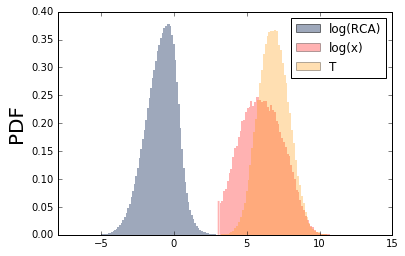

In [158]:
f = df.loc[df.RCA > 0]
plt.hist(f.log_RCA.values, 100, normed = 'PDF', edgecolor = 'None', label = 'log(RCA)', alpha = .5, color= '#3f5378')
plt.ylabel('PDF',fontsize = 20)

dg = df.sample(200000).replace(-np.inf, np.nan).dropna()
plt.hist(dg.log_RCA+dg.Tc+dg.Tp-dg.Tw, 70, edgecolor = 'None', normed=True, label = 'log(x)',alpha = .3, color = 'r')

T = dg.Tc+dg.Tp-dg.Tw
plt.hist(T.unique(), 70, edgecolor = 'None', normed=True, label = 'T',alpha = .3, color = '#ff9800')

plt.legend()
plt.xlim(-8, 15)
plt.show()
# df.columns

### Distribution of RCA

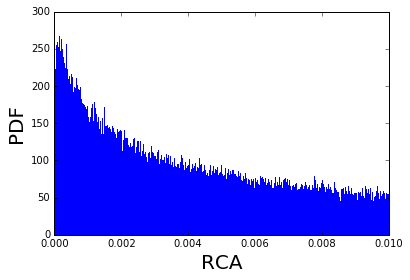

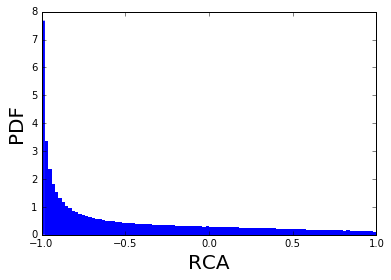

In [58]:
f = df.loc[(df.RCA < 0.01) & (df.RCA > 0)]
plt.hist(f.RCA.values, 1000, normed = 'PDF', edgecolor = 'None')
plt.xlabel('RCA',fontsize = 20)
plt.ylabel('PDF',fontsize = 20)
plt.xlim(0,0.01)
plt.show()

# # Symmetric RCA
# f = df.loc[(df.RCA > 0)]
# plt.hist(np.true_divide(f.RCA.values - 1,f.RCA.values + 1), 100, normed = 'PDF', edgecolor = 'None')
# plt.xlabel('RCA',fontsize = 20)
# plt.ylabel('PDF',fontsize = 20)
# plt.show()

### Distribution of log(x_cp)

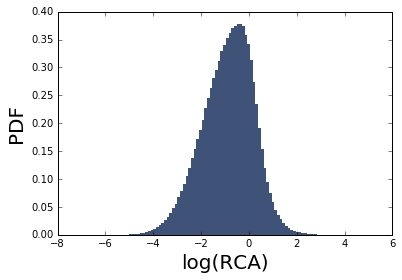

In [148]:
f = df.loc[df.RCA > 0]
plt.hist(f.log_RCA.values, 100, normed = 'PDF', edgecolor = 'None', label = 'log(RCA)', color = '#3f5378')
plt.ylabel('PDF',fontsize = 20)
plt.xlabel('log(RCA)',fontsize = 20)
plt.show()

### Distribution of T

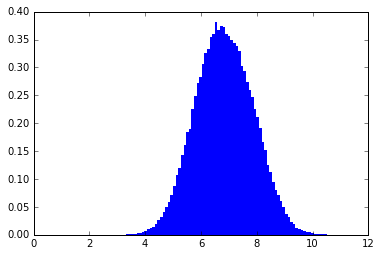

In [39]:
T = dg.Tc+dg.Tp-dg.Tw
plt.hist(T.unique(), 100, edgecolor = 'None', normed=True)
plt.show()

### Distribution of datapoints in the T, log(RCA) plane

d = df.sample(1000)
plt.scatter(d.Tc+d.Xp-d.Xw, d.log_RCA,edgecolor = 'None',alpha = 0.01)
plt.plot(np.arange(3,-9,-1), color = 'k')
plt.xlim(2,11)
plt.ylim(-5,4)
plt.xlabel('T = Tc + Tp - Tw')
plt.ylabel('log_RCA')
plt.show()

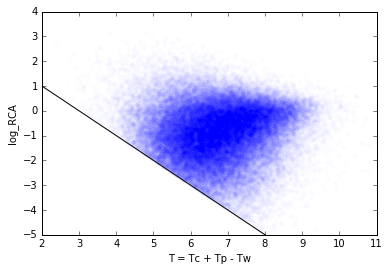

In [62]:
d = df.sample(100000) 
plt.scatter(d.Tc+d.Tp-d.Tw, d.log_RCA,edgecolor = 'None',alpha = 0.01) 
plt.plot(np.arange(3,-9,-1), color = 'k') 
plt.xlim(2,11) 
plt.ylim(-5,4) 
plt.xlabel('T = Tc + Tp - Tw') 
plt.ylabel('log_RCA') 
plt.show()


In [143]:
ccode_sel = np.random.choice(df.ccode.unique(), 20)
pcode_sel = np.random.choice(df.pcode.unique(), 20)

fit_data = df[['ccode','pcode','year','RCA_bin_start','RCA_bin_end']].loc[(df['ccode'].isin(ccode_sel))&
                                                                         (df['pcode'].isin(pcode_sel))]

fit_data = pd.get_dummies(fit_data, columns=['ccode','pcode'])

import statsmodels.api as sm

X = fit_data.drop([u'year', u'RCA_bin_end'], axis = 1)
y = fit_data['RCA_bin_end']

res2 = sm.OLS(y, X).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:            RCA_bin_end   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     181.5
Date:                Wed, 27 Sep 2017   Prob (F-statistic):               0.00
Time:                        14:14:40   Log-Likelihood:                 893.37
No. Observations:                3960   AIC:                            -1709.
Df Residuals:                    3921   BIC:                            -1464.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
RCA_bin_start     0.7621      0.010     73.791

In [ ]:


#todo lo que cambia con los anios deberia tener el mismo trato que la col de RCA_yr, ejemplo proximity
def extend_dataset(data, base_cols = [0], step = 1, binary = True, continuous_period = True):
    """
    TODO...
    """

#     w_cols = data[[col for col in data if 'w_' in col]]
    RCA_bin_cols = data[[col for col in data if 'RCA' and 'bin' in col]]
    RCA_yr_cols = data[[col for col in data if 'RCA' in col and 'bin' not in col]]
    cp_cols = data[['ccode','pcode']]

    c = 0
    for i in base_cols:

        if continuous_period:
            RCA_ini = RCA_yr_cols.iloc[:,i : i + step].mean(axis = 1)
#             w_ini = w_cols.iloc[:,i : i + step].mean(axis = 1)
            RCA_fin = RCA_yr_cols.iloc[:, i+step  : i+2*step].mean(axis = 1)

            RCA_bin_ini = RCA_bin_cols.iloc[:, i : i+step].mean(axis = 1)
            RCA_bin_fin = RCA_bin_cols.iloc[:, i+step  : i+2*step].mean(axis = 1)

        else:
            RCA_ini = RCA_yr_cols.iloc[:,i]
            RCA_fin = RCA_yr_cols.iloc[:, i + step]
#             w_ini = w_cols.iloc[:,i]

            RCA_bin_ini = RCA_bin_cols.iloc[:, i ]
            RCA_bin_fin = RCA_bin_cols.iloc[:, i+step]
        
        
#         batch = cp_cols.join([w_ini, RCA_ini, RCA_fin, RCA_bin_ini, RCA_bin_fin])
#         batch.columns = ['ccode','pcode','w','RCA', 'RCA_fin', 'RCA_bin_start', 'RCA_bin_end']
        
        batch = cp_cols.join([RCA_ini, RCA_fin, RCA_bin_ini, RCA_bin_fin])
        batch.columns = ['ccode','pcode','RCA', 'RCA_fin', 'RCA_bin_start', 'RCA_bin_end']
        
        batch['year'] = int(RCA_yr_cols.columns[i][-4:])


        if binary:
            batch = batch.loc[batch.RCA_bin_start.isin([0, 1]) & batch.RCA_bin_end.isin([0, 1])]
            batch.RCA_bin_start = batch.RCA_bin_start.astype(int)
            batch.RCA_bin_end = batch.RCA_bin_end.astype(int)

        if c == 0:
            ext_data = batch
            c = 1
        else:
            ext_data = ext_data.append(batch)
    return ext_data
